In [1]:
import numpy as np
import pandas as pd 

import os
import json

from tqdm import tqdm

import cv2

#!pip install umap-learn
import umap

# Sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier as RFC


import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

In [2]:
MOUNT = False
if MOUNT == True:
  from google.colab import drive
  drive.mount('/content/drive')
  !unzip -q '/content/drive/MyDrive/benetech-making-graphs-accessible.zip' -d '/content'

# Data Preparation

In [3]:
root_dir = "/content/benetech-making-graphs-accessible"

train_folder = os.path.join(root_dir, 'train')
test_folder = os.path.join(root_dir, 'test')

train_annotations_folder = os.path.join(train_folder, 'annotations')
train_images_folder = os.path.join(train_folder, 'images')

test_images_folder = os.path.join(test_folder, 'images')

## Data Loading Method

In [4]:
def normalize_image(img):
    img_min = img.min()
    img_max = img.max()
    img_norm = (img - img_min) / (img_max - img_min)
    return img_norm

def load_annotation(json_file):
    with open(json_file, 'r') as f:
        annotation = json.load(f)
    return annotation

def load_image(image_file):
    # Load image
    #if GPU == True:

    img = cv2.imread(image_file)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = normalize_image(img)
    return img

## Data Augmentation Method

In [5]:
import random

# Random crop
def random_crop(imgs, imgs_augmented):
    for img in imgs:
        h, w = img.shape[:2]
        crop_w, crop_h = w // 2, h // 2
        x1 = random.randint(0, w - crop_w)
        y1 = random.randint(0, h - crop_h)
        x2 = x1 + crop_w
        y2 = y1 + crop_h
        img = img[y1:y2, x1:x2]
        img = cv2.resize(img, (128, 128))
        imgs_augmented.append(img)
    return imgs_augmented

# Random rotation
def random_rotation(imgs, imgs_augmented):
    for img in imgs:
        rows, cols = img.shape[:2]
        angle = random.randint(-30, 30)
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        img = cv2.warpAffine(img, M, (cols, rows))
        img = cv2.resize(img, (128, 128))
        imgs_augmented.append(img)
    return imgs_augmented

# Random mixed transformation
def random_mixedtran(imgs, imgs_augmented):
    for img in imgs:
        h, w = img.shape[:2]
        crop_w, crop_h = w // 2, h // 2
        x1 = random.randint(0, w - crop_w)
        y1 = random.randint(0, h - crop_h)
        x2 = x1 + crop_w
        y2 = y1 + crop_h
        img = img[y1:y2, x1:x2]

        if np.random.rand() < 0.5:
            img = cv2.flip(img, 1)

        angle = np.random.randint(-15, 15)
        M = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), angle, 1)
        img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

        img = cv2.resize(img, (128, 128))
        imgs_augmented.append(img)
    return imgs_augmented

## Error Analysis Method

In [6]:
def print_mislabels(test_labels, pred_labels):
    mislabeled_indices = np.where(test_labels != pred_labels)
    true_labeled_labels = test_labels[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    mislabeled_indices = np.concatenate(mislabeled_indices)
    mislabeled_labels_dict = {idx: {"true_labeled_labels": test_labels[idx], "mislabeled_labels": pred_labels[idx]} for idx in mislabeled_indices}
    return mislabeled_labels_dict

## Data Loading

### Path

In [7]:
# Get all the training images and annotations path
train_images_path = sorted([os.path.join(train_images_folder, f) for f in os.listdir(train_images_folder)])
train_annotations_path = sorted([os.path.join(train_annotations_folder, f) for f in os.listdir(train_annotations_folder)])

test_images_path = sorted([os.path.join(test_images_folder, f) for f in os.listdir(test_images_folder)])

print('# of train images:', len(train_images_path))
print('# of train annotations:', len(train_annotations_path))
print('# of test images:', len(test_images_path))

# of train images: 60578
# of train annotations: 60578
# of test images: 5


### Anotation

In [8]:
# Load all the training images and annotations
train_images = [load_image(f) for f in tqdm(train_images_path)]
train_annotations = [load_annotation(f) for f in tqdm(train_annotations_path)]

100%|██████████| 60578/60578 [00:17<00:00, 3411.91it/s]


*Chart Type + Path Dataframe*

In [9]:
from sklearn.preprocessing import LabelEncoder

# Encode the chart-type
label_encoder = LabelEncoder()

train_charts_type = [a['chart-type'] for a in train_annotations]
train_charts_numtype = label_encoder.fit_transform(train_charts_type)
y = list(train_charts_numtype)

print(np.unique(train_charts_numtype))
print(np.unique(train_charts_type))

#test_charts_type = label_encoder.fit_transform(['line', 'line', 'vertical bar', 'dot', 'vertical bar'])
#test_charts_numtype = label_encoder.fit_transform(test_charts_type)
#y_test = test_charts_numtype

[0 1 2 3 4]
['dot' 'horizontal_bar' 'line' 'scatter' 'vertical_bar']


In [10]:
indices_1 = np.where(np.array(y) == 1)
indices_1 = np.concatenate(indices_1)
train_images_1 = [train_images[idx] for idx in indices_1]
augmented_num = 30
train_images_1_augmented = []
for i in tqdm(range(augmented_num)):
  random_mixedtran(train_images_1, train_images_1_augmented)

100%|██████████| 30/30 [00:00<00:00, 83.42it/s]


## PCA + UMAP + SVM

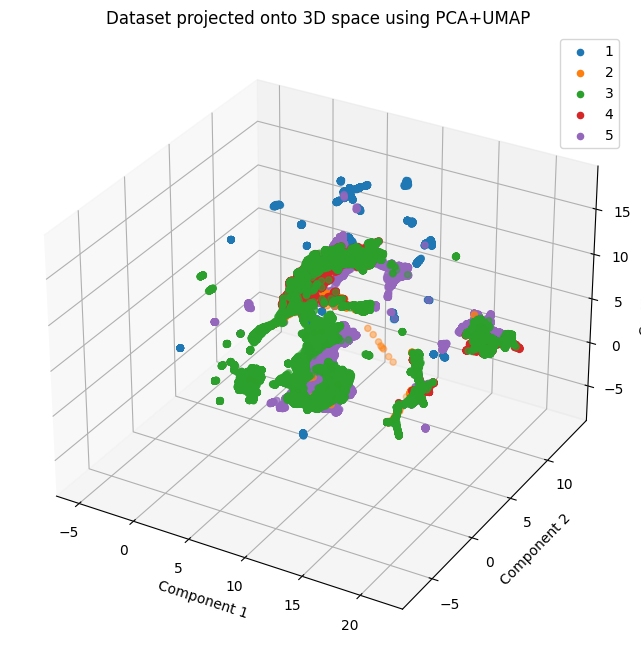

In [11]:
from sklearn.model_selection import train_test_split
X = np.array([np.reshape(train_image, (128*128*1)) for train_image in train_images])
y = np.array(y)
pca = PCA(n_components=50)
pca.fit(X)
X_pca = pca.transform(X)
umap_model = umap.UMAP(n_components=3, min_dist = 0.1)
umap_model.fit(X_pca)
X_umap = umap_model.transform(X_pca)

X_1_augmented = np.array([np.reshape(train_image, (128*128*1)) for train_image in train_images_1_augmented])
y_1_augmented = np.array([1]*len(train_images_1_augmented))
X_1_pca_augmented = pca.transform(X_1_augmented)
X_1_umap_augmented = umap_model.transform(X_1_pca_augmented)

X_pca_augmented = np.concatenate((X_pca, X_1_pca_augmented))
X_umap_augmented = np.concatenate((X_umap, X_1_umap_augmented))
y_augmented = np.concatenate((y, y_1_augmented))

# shuffle X_train and y based on the permutation of indices
indices = np.random.permutation(y_augmented.shape[0])
X_pca_augmented = X_pca_augmented[indices]
X_umap_augmented = X_umap_augmented[indices]
y_augmented = y_augmented[indices]

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111, projection='3d')
for i in range(len(np.unique(y_augmented))):
    ax.scatter(X_umap_augmented[y_augmented==i, 0], X_umap_augmented[y_augmented==i, 1], X_umap_augmented[y_augmented==i, 2], label=f'{i+1}', s = 1)
ax.legend(loc='best', fontsize=10)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('Dataset projected onto 3D space using PCA+UMAP')
plt.show()

X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.1, random_state=42)
X_pca_train_augmented, X_pca_test_augmented, y_train_augmented, y_test_augmented = train_test_split(X_pca_augmented, y_augmented, test_size=0.1, random_state=42)

In [12]:
umap_model = umap.UMAP(n_components=10, min_dist = 0.1)
X_umap_train_augmented = umap_model.fit_transform(X_pca_train_augmented, y_train_augmented)
X_umap_test = umap_model.transform(X_pca_test)

In [13]:
# SVM
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_umap_train_augmented, y_train_augmented)

SVC()

In [14]:
# Predict
y_pred = svm_classifier.predict(X_umap_test)

In [15]:
print("Accuracy: %.2f %%" % (100 * accuracy_score(y_test, y_pred)))
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 98.79 %
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       528
           1       0.75      0.60      0.67         5
           2       0.98      0.99      0.99      2544
           3       0.98      0.99      0.98      1050
           4       1.00      0.98      0.99      1931

    accuracy                           0.99      6058
   macro avg       0.94      0.91      0.92      6058
weighted avg       0.99      0.99      0.99      6058



In [16]:
# print_mislabels(y_test, y_pred)